In [1]:
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt, PIDController, Kvaerno5
from discrete_exterior_calculus import DEC
from icosphere import icosphere
from jax import config
import probabilistic_solve_icosphere
import matplotlib.pyplot as plt


config.update("jax_enable_x64", True)


# nu:       1   2   3   4    5    6    7    8    9    10
# vertices: 12, 42, 92, 162, 252, 362, 492, 642, 812, 1002
nu = 1
vertices, faces = icosphere(nu=nu)
mesh_name = f"icosphere_v={len(vertices)}"
mesh = DEC.Mesh(vertices, faces)

print("highest vertex: ", jnp.max(vertices))

zmost_point = jnp.argmax(vertices[:, 2])
zleast_point = jnp.argmin(vertices[:, 2])
xmost_point = jnp.argmax(vertices[:, 0])
xleast_point = jnp.argmin(vertices[:, 0])
ymost_point = jnp.argmax(vertices[:, 1])
yleast_point = jnp.argmin(vertices[:, 1])

n = len(vertices)
q = 1


# Define the vector field
def vector_field(t, y, args):
    # Extract u and v from y
    return mesh.laplace_matrix @ y


# Define the ODE term
term = ODETerm(vector_field)

steps = 1000

end_time = 10
# Solver settings
solver = Kvaerno5()  # Runge-Kutta method
saveat = SaveAt(
    ts=jnp.linspace(0, end_time, steps)
)  # Save at 100 evenly spaced time points
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

# Initial conditions
u0 = jnp.zeros(n)  # Initial condition for u (e.g., zero displacement)
u0 = u0.at[ymost_point].set(2.0)  # Example: Displace the middle point
u0 = u0.at[yleast_point].set(-2.0)  # Example: Displace the middle point

# Solve the system
sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=end_time,
    dt0=0.01,
    y0=u0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=50000,
)

# Extract solutions
diffrax_sol = sol.ys[:, :n]  # Displacement solutions over time

highest vertex:  0.85065080835204


(1000, 48, 48)


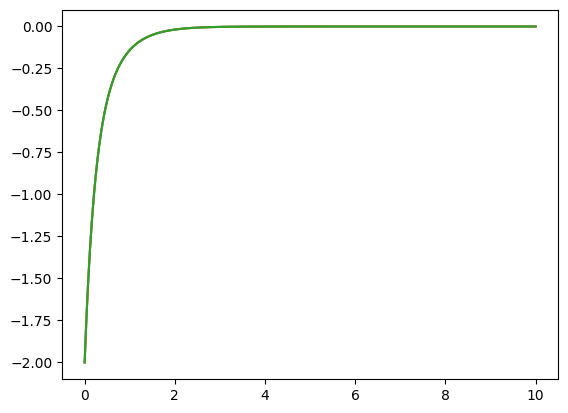

In [15]:
import jax
import jax.numpy as jnp
from probdiffeq import ivpsolve, ivpsolvers, taylor, stats
from probdiffeq.impl import impl

jax.config.update("jax_platform_name", "cpu")


@jax.jit
def vf(y, *, t):  # noqa: ARG001
    return mesh.laplace_matrix @ y


t0, t1 = 0.0, 10.0

impl.select("dense", ode_shape=(12,))

q = 3  # THIS IS THE ONLY NUMBER I'VE BEEN CHANGING

ibm = ivpsolvers.prior_ibm(num_derivatives=q)
ts0 = ivpsolvers.correction_ts1(ode_order=1)

strategy = ivpsolvers.strategy_smoother(ibm, ts0)
solver = ivpsolvers.solver(strategy)

tcoeffs = taylor.odejet_padded_scan(lambda y: vf(y, t=t0), (u0,), num=q)
output_scale = 1.0  # or any other value with the same shape
init = solver.initial_condition(tcoeffs, output_scale)

dt0 = ivpsolve.dt0(lambda y: vf(y, t=t0), (u0,))  # or use e.g. dt0=0.1
solution = ivpsolve.solve_fixed_grid(
    vf, init, grid=jnp.linspace(0, 10, steps), solver=solver
)

marginals = stats.calibrate(solution.marginals, solution.output_scale)
print(marginals.cholesky.shape)
cov_mats = jnp.einsum("ijk,ilk->ijl", marginals.cholesky, marginals.cholesky)

std = jnp.sqrt(cov_mats[:, yleast_point, yleast_point])
mean = solution.u[:, yleast_point]

# Looking at the solution
plt.plot(solution.t, mean)
plt.plot(solution.t, mean + 3.0 * std)
plt.plot(solution.t, mean - 3.0 * std)

In [3]:
init[0].init.mean

Array([  0.        ,   1.4472136 , -10.47213595,   0.        ,
        -1.4472136 ,  10.47213595,   2.        ,  -7.23606798,
        31.41640786,   0.        ,   1.4472136 , -10.47213595,
         0.        ,   1.4472136 , -10.47213595,   0.        ,
        -1.4472136 ,  10.47213595,   0.        ,  -1.4472136 ,
        10.47213595,   0.        ,   1.4472136 , -10.47213595,
        -2.        ,   7.23606798, -31.41640786,   0.        ,
        -1.4472136 ,  10.47213595,   0.        ,  -1.4472136 ,
        10.47213595,   0.        ,   1.4472136 , -10.47213595],      dtype=float64)

Discretized IWP prior
False
False
Filtered
(1000, 36)
(1000, 36)
(36, 36)
(100, 36)
has nan:  mean: False std: False


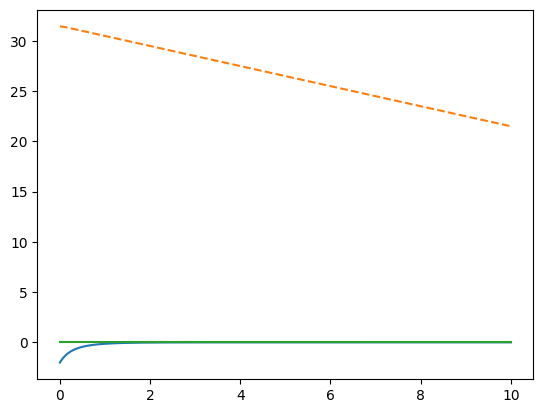

In [6]:
ts = 1000
domain = probabilistic_solve_icosphere.return_times
means, std = probabilistic_solve_icosphere.solve(
    isosphere_nu=1,
    timesteps=ts,
    derivatives=2,
    prior="iwp",
)
print(means.shape)

print("has nan: ", "mean:", jnp.any(jnp.isnan(means)), "std:", jnp.any(jnp.isnan(std)))

plt.plot(sol.ts, diffrax_sol[:, yleast_point], label="Diffrax")
plt.plot(domain, means[:, yleast_point], label="Probabilistic", linestyle="--")
plt.plot(domain, [0.0] * 100, label="Initial")

# Testing calibration

In [5]:
# other = jnp.interp(solution.t, sol.ts, diffrax_sol[:, yleast_point])
diff = (diffrax_sol - solution.u[:, :12])[1:]

stat = 0
for time in range(1, steps):
    stat += jnp.sum(
        diff[time] @ jnp.linalg.inv(cov_mats[time, :12, :12]) @ diff[time].T
    )

print(diff.shape)

print(stat, "expected:", steps - 1)

(999, 12)
111.24658263693252 expected: 999
